# Calculating the Climatological and Anomaly Values for Selected CBP Stations

## Notebook Overview
- Select Chesapeake Bay Program (CBP) stations with sufficient SST observation temporal coverage at the appropriate depths to compute a climatology.
- Extract one SST value at each location and day, if there are observations at multiple depths.
- Compute the seasonal climatology of the mixed layer from the chosen stations.
- Compute the observed SST anomalies.
- Save the observed SST values, the climatological value, and the observed SST anomaly for location and observation day.

### Supplemental information
- [Chesapeake Bay Program station names](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/map_of_mainstem_and_tributary_monitoring_stations.pdf)
- [Chesapeake Bay Program data guide](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/cbwqdb2004_rb.pdf)

## Analysis

In [1]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

Update the `REPO_ROOT` to the location of the `chesapeake_mhw` folder on your machine.

In [2]:
SAVE_FIGS = False
REPO_ROOT = Path('/Users/rwegener/repos/chesapeake_mhw')

### Read Data

In [3]:
# Read the csv into a pandas dataframe
cols = ['EventId', 'Station', 'SampleDate', 'SampleTime', 'Unit',
        'Depth', 'Layer','MeasureValue', 'Latitude', 'Longitude']
path = REPO_ROOT / 'data/raw/WaterQuality_ChesapeakeBayProgram_20030101_20221231.csv'
wq = pd.read_csv(path, usecols=cols, parse_dates=[2])

### Filter, Average, and Save Raw SST Observations

In [4]:
# Only consider measurements between 1 and 3 meters depth
wq_stations = wq[(wq.Depth > 1) & (wq.Depth < 3)]

In [5]:
# Take average value of observations at those depths
wq_stations = wq_stations.groupby(['Station', 'SampleDate']).mean(numeric_only=True).reset_index()

In [6]:
# Clean un-needed columns
wq_stations = wq_stations.drop(['EventId', 'Depth'], axis=1)
wq_stations = wq_stations.rename(columns={'MeasureValue': 'sst_cbp'})

File has one SST value per lat/lon/date. Values are the average of all the observations between 1m and 3m depth.

In [7]:
wq_stations

,Station,SampleDate,sst_cbp,Latitude,Longitude
0,1AAUA001.39,2007-03-22,8.3,38.4000,-77.3200
1,1AAUA001.39,2007-06-18,26.2,38.4000,-77.3200
2,1AAUA001.39,2007-10-29,14.5,38.4000,-77.3200
3,1AAUA001.39,2007-12-10,5.2,38.4000,-77.3200
4,1AAUA001.39,2008-02-04,4.9,38.4000,-77.3200
...,...,...,...,...,...
51139,ZDM0003,2004-07-08,27.7,38.9362,-76.5067
51140,ZDM0003,2004-08-05,29.0,38.9362,-76.5067
51141,ZDM0003,2004-08-19,26.4,38.9362,-76.5067
51142,ZDM0003,2004-09-15,24.5,38.9362,-76.5067


In [10]:
# Save output
path = REPO_ROOT / 'data/interim' / 
    # NEW NAME -- 'selected_cbp_stations_sst.csv'
    'cbp_stations_climatology_raw_filtered.csv' # TODO rename this. It isn't a clim and filtered
    # is pretty vague
)
wq_stations.to_csv(path, index=False)

### Preprocessing

In [8]:
# Create a list of all the station names
stations = wq_stations.groupby('Station').count().index

In [9]:
# Create a dataframe with the number of observations per station and month
counts = wq_stations.groupby(['Station', wq_stations.SampleDate.dt.year, wq_stations.SampleDate.dt.month]).count()['sst_cbp']
# Format the dataframe more clearly
counts = pd.DataFrame(counts)
counts = counts.rename(columns={'sst_cbp': 'ObsCount'})
counts.index = counts.index.set_names(['Station', 'year', 'month'])

### Create a list of stations that have enough data to compute a climatology

Create a filtered list of stations that have at least 12 years of observations in all months and 18 observations in 10 of the months.

In [10]:
stations_filtered = []  # TODO rename to clim_elibigle_stations
completeness_df = pd.DataFrame(
    columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 
               'Nov', 'Dec']
)

for station in stations:
    # extract station
    df = counts.loc[station]
    # preprocessing
    df = df.reset_index()
    matrix = df.pivot(index='year', columns='month')
    
    # Add to filtered stations if it meets the condition
    if (matrix.sum() < 12).sum() > 0:
        # If any month does not have at least 12 years with an obs (60% coverage)
        # do not consider it
        continue
    # Check that there are at least 18 months with obs (90% coverage) in 10 of the months
    if ((~matrix.isna()).sum() >= 18).sum() >= 10:
        stations_filtered.append(station)
        # optional - plot a heatmap for the individual station
        # sns.heatmap(matrix)
        # plt.title(station)
        # plt.show()
        # plt.close()
        completeness_df.loc[station] = (~matrix.isna()).sum().values

print(len(stations_filtered), 'stations identified.')

48 stations identified.


### Filter stations list to only include climatology-eligible stations

In [11]:
wq_stations = wq_stations[wq_stations.Station.isin(stations_filtered)]

### Plot location of the climatology stations

In [12]:
wq_counts = wq_stations.groupby('Station').mean(numeric_only=True)[['Latitude', 'Longitude']]
wq_counts['Count'] = wq_stations.groupby('Station').count()['sst_cbp']

In [13]:
geoWQ = gpd.GeoDataFrame(
    wq_counts, geometry=gpd.points_from_xy(wq_counts['Longitude'], wq_counts['Latitude']), 
    crs='epsg:4326')

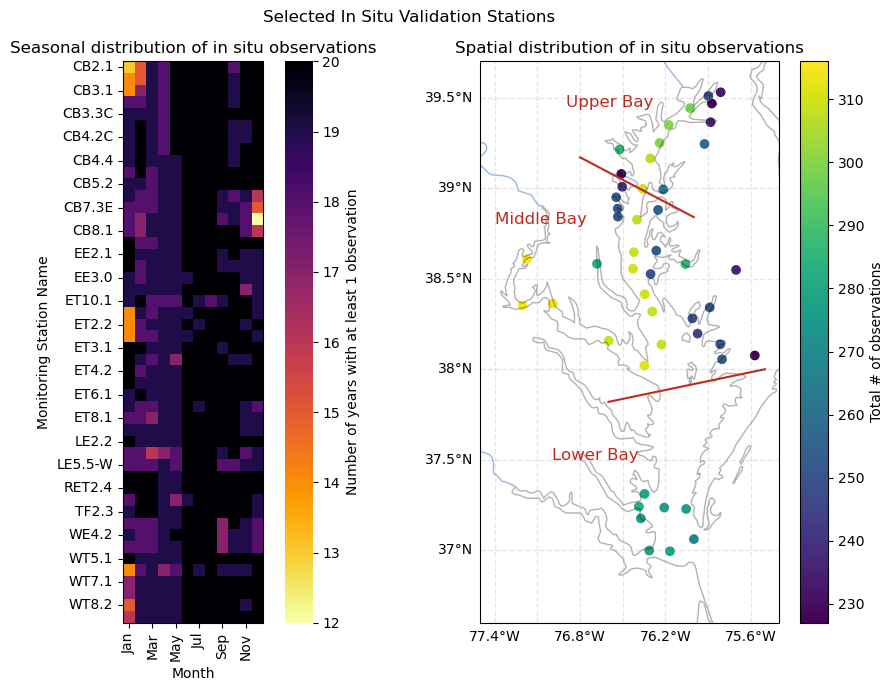

In [14]:
# ax1 = plt.subplot(121)
# ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, 
                         # gridspec_kw={'width_ratios':[5, 2]}, 
                         figsize=(10, 7))
                        # gridspec_kw={'width_ratios':[2, 1]})  # , 'height_ratios':[2,1]})
fig.suptitle('Selected In Situ Validation Stations')

# fig.set_size_inches(9, 6)
# fig.suptitle('Locations of most frequently sampled in situ locations')

# Add background features
axes[1].add_feature(cfeature.COASTLINE, alpha=0.3)
axes[1].add_feature(cfeature.BORDERS, linestyle=':')
axes[1].add_feature(cfeature.RIVERS)
# ax.coastlines()

axes[1].set_extent([-77.5, -75.4, 36.6, 39.7])

# Add and format gridlines. Remove top and right labels
gl = axes[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.top_labels, gl.right_labels = False, False

# Add seasonal distribution
# attempted and failed to make colorbar discrete
# making colorbar discrete is fine; struggling with label location
# cmap = plt.get_cmap('inferno_r', np.max(completeness_df.values) - np.min(completeness_df.values) + 1)
axes[0].set_title('Seasonal distribution of in situ observations')
sns.heatmap(completeness_df, ax=axes[0], cmap='inferno_r',
                   # linewidths=0.2,
            cbar_kws={'label': 'Number of years with at least 1 observation'})
axes[0].set_ylabel('Monitoring Station Name')
axes[0].set_xlabel('Month')
axes[0].set_xticks([0.5, 2.5, 4.5, 6.5, 8.5, 10.5])
axes[0].set_xticklabels(['Jan','Mar','May','Jul', 'Sep', 'Nov'])

# Plot in situ locations
axes[1].set_title('Spatial distribution of in situ observations')
geoWQ.plot(ax=axes[1], column='Count', legend=True, legend_kwds={'label': "Total # of observations"})
# Add upper / middle / lower locations
axes[1].plot([-76.8, -76.0], [39.17, 38.84], color='#bd2b20')  # upper/mid
axes[1].plot([-76.6, -75.5], [37.82, 38], color='#bd2b20')  # mid/lower
axes[1].text(-76.9, 39.45, 'Upper Bay', color='#bd2b20', size=12)
axes[1].text(-77.4, 38.8, 'Middle Bay', color='#bd2b20', size=12)
axes[1].text(-77.0, 37.5, 'Lower Bay', color='#bd2b20', size=12)


plt.tight_layout()

if SAVE_FIGS: 
    plt.savefig('../../figures/insitu_distribution.png', dpi=400, 
            bbox_inches='tight')

**Most sampled stations from several areas of the bay**

- CB5.1 -- main stem outside the Patuxent River
- RET2.4 -- up the Potomac River
- CB7.2 -- main stem near the exit of the Bay

In [27]:
len(stations_filtered)

48

## Compute the Climatologial Value for each Depth and Location

It's possible this observation count isn't strictly necessary for the process, it was something I did while just trying to get a handle on how many values there were.

In [17]:
wq_stations.sort_values(['Station', 'SampleDate'])

,Station,SampleDate,sst_cbp,Latitude,Longitude
1623,CB2.1,2003-01-15,1.10,39.44149,-76.02599
1624,CB2.1,2003-03-12,2.00,39.44149,-76.02599
1625,CB2.1,2003-04-09,6.80,39.44149,-76.02599
1626,CB2.1,2003-04-23,13.00,39.44149,-76.02599
1627,CB2.1,2003-05-07,15.70,39.44149,-76.02599
...,...,...,...,...,...
40539,WT8.3,2022-08-09,29.40,38.84250,-76.53410
40540,WT8.3,2022-09-13,25.65,38.84250,-76.53410
40541,WT8.3,2022-10-12,16.75,38.84250,-76.53410
40542,WT8.3,2022-11-14,12.75,38.84250,-76.53410


In [33]:
# Determine how many observations there are for each station in each month/year
counts = wq_stations.groupby(
    ['Station', wq_stations.SampleDate.dt.year, wq_stations.SampleDate.dt.month]
).count()['sst_cbp']
counts = pd.DataFrame(counts)
counts = counts.rename({'sst_cbp': 'ObsCount'}, axis=1)
counts.index = counts.index.set_names(['Station', 'year', 'month'])

In [19]:
# not used?
# counts['avg_sst'] = wq_stations.groupby(
#     ['Station', wq_stations.SampleDate.dt.month]
# )['sst_cbp'].mean()

In [26]:
counts

ObsCount  avg_sst
Station     year month                   
1AAUA001.39 2007 3             1      NaN
                 6             1      NaN
                 10            1      NaN
                 12            1      NaN
            2008 2             1      NaN
...                          ...      ...
ZDM0003     2004 6             1      NaN
                 7             1      NaN
                 8             2      NaN
                 9             1      NaN
                 10            1      NaN

[41858 rows x 2 columns]

In [22]:
wq_clim = wq_stations.groupby(
    ['Station', wq_stations.SampleDate.dt.month]
)['sst_cbp'].mean(numeric_only=True)

In [24]:
wq_clim = wq_clim.dropna().sort_index().reset_index()  \
    .rename(columns={'SampleDate': 'Month', 'sst_cbp': 'clim_cbp'})

## Compute Anomalies

In [30]:
wq_stations['Month'] = wq_stations.SampleDate.dt.month

/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_2107/987881273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wq_stations['Month'] = wq_stations.SampleDate.dt.month


In [35]:
wq.sort_values(['Station', 'SampleDate'])

,Station,SampleDate,sst_cbp,Latitude,Longitude,clim_cbp,anom_cbp
0,CB2.1,2003-01-15,1.10,39.44149,-76.02599,3.138462,-2.038462
13,CB2.1,2003-03-12,2.00,39.44149,-76.02599,6.000000,-4.000000
32,CB2.1,2003-04-09,6.80,39.44149,-76.02599,12.712000,-5.912000
33,CB2.1,2003-04-23,13.00,39.44149,-76.02599,12.712000,0.288000
57,CB2.1,2003-05-07,15.70,39.44149,-76.02599,18.592593,-2.892593
...,...,...,...,...,...,...,...
13041,WT8.3,2022-08-09,29.40,38.84250,-76.53410,27.182609,2.217391
13063,WT8.3,2022-09-13,25.65,38.84250,-76.53410,23.529545,2.120455
13086,WT8.3,2022-10-12,16.75,38.84250,-76.53410,17.276087,-0.526087
13106,WT8.3,2022-11-14,12.75,38.84250,-76.53410,10.955000,1.795000


In [32]:
wq = pd.merge(wq_stations, wq_clim, on=['Station', 'Month'])  \
    .drop(columns=['Month'])

In [33]:
wq['anom_cbp'] = wq['sst_cbp'] - wq['clim_cbp']

In [40]:
# Rearrange columns for neatness
anom_cbp = wq.pop('anom_cbp')
wq.insert(3, anom_cbp.name, anom_cbp)

In [41]:
wq

,Station,SampleDate,sst_cbp,anom_cbp,Latitude,Longitude,clim_cbp
0,CB2.1,2003-01-15,1.10,-2.038462,39.44149,-76.02599,3.138462
1,CB2.1,2004-01-14,0.30,-2.838462,39.44149,-76.02599,3.138462
2,CB2.1,2005-01-13,4.90,1.761538,39.44149,-76.02599,3.138462
3,CB2.1,2006-01-12,4.60,1.461538,39.44149,-76.02599,3.138462
4,CB2.1,2007-01-12,5.30,2.161538,39.44149,-76.02599,3.138462
...,...,...,...,...,...,...,...
13157,WT8.3,2018-02-15,3.60,-0.273684,38.84250,-76.53410,3.873684
13158,WT8.3,2019-02-11,3.90,0.026316,38.84250,-76.53410,3.873684
13159,WT8.3,2020-02-13,7.00,3.126316,38.84250,-76.53410,3.873684
13160,WT8.3,2021-02-08,3.30,-0.573684,38.84250,-76.53410,3.873684


In [49]:
# NEW NAMING CONVENTION
path = REPO_ROOT / 
    'data/interim' /  
    'cbp_temps_selected_stations_with_climatology.csv'
)
wq.to_csv(path, index=False)

In [47]:
# OLD NAMING CONVENTION
path = REPO_ROOT /  
    'data/interim' /  
    'cbp_stations_climatology_anomaly_filtered_1-3m.csv'
    # TODO I don't think this is the filename I want -- remove 1-3m part
)
wq.to_csv(path, index=False)

In [48]:
wq

,Station,SampleDate,sst_cbp,Latitude,Longitude,clim_cbp,anom_cbp
0,CB2.1,2003-01-15,1.10,39.44149,-76.02599,3.138462,-2.038462
1,CB2.1,2004-01-14,0.30,39.44149,-76.02599,3.138462,-2.838462
2,CB2.1,2005-01-13,4.90,39.44149,-76.02599,3.138462,1.761538
3,CB2.1,2006-01-12,4.60,39.44149,-76.02599,3.138462,1.461538
4,CB2.1,2007-01-12,5.30,39.44149,-76.02599,3.138462,2.161538
...,...,...,...,...,...,...,...
13157,WT8.3,2018-02-15,3.60,38.84250,-76.53410,3.873684,-0.273684
13158,WT8.3,2019-02-11,3.90,38.84250,-76.53410,3.873684,0.026316
13159,WT8.3,2020-02-13,7.00,38.84250,-76.53410,3.873684,3.126316
13160,WT8.3,2021-02-08,3.30,38.84250,-76.53410,3.873684,-0.573684


### Isolating just one depth observation per location --- Switch back to this?

Select one measurement for each location and time, in each case selecting the measurement closest to 2 meters depth.

In [ ]:
def find_correct_depth(df):
    if len(df) > 1:
        # Get the row with the depth closest to 2 meters
        df = df.iloc[(df['Depth']-2).abs().argsort()[:1]]
    # if there was only 1 row to begin with, just return that one
    return df

In [ ]:
wq = wq.groupby(['Station', 'SampleDate', 'SampleTime']) \
                .apply(find_correct_depth)

In [ ]:
# wq.Depth.unique()

## Exploring Feasibility of creating a climatology

In [ ]:
cb51 = wq_clim[wq_clim.Station == 'CB5.1'].reset_index()
cb72 = wq_clim[wq_clim.Station == 'CB7.2'].reset_index()

In [ ]:
cb51.SampleDate.hist(bins=20)

Seems to be one station per month. Exact dates do not repeat exactly. We can get monthly climatologies, then. To compare to the sst I could either
1. average a month together
2. pick out specifically the same days as the in situ

I'm leaning toward no. 2, because it feels like a more similar comparison

In [ ]:
cb51.groupby([cb51.SampleDate.dt.month, 'Depth']).count()

Honestly at least between these two the depths are more standard than I gave them credit for. I can probably avoid interpolation, but I will still drop depths with fewer than a certain number of points.

In [ ]:
depths_cb72 = cb72.Depth.unique()

In [ ]:
depths_cb72

In [ ]:
depths = cb51.Depth.unique()

In [ ]:
depths

This is the function that is going to have to get more complex. Need to check counts, for example.

## Plotting Climatologies

### Preprocessing

1 - adding relevant datetime columns

In [ ]:
wq['month'] = wq['SampleDate'].dt.month
wq['day'] = wq['SampleDate'].dt.day

2 - sorting into each station

In [ ]:
cb51 = wq[wq.Station == 'CB5.1'].reset_index()
ret24 = wq[wq.Station == 'RET2.4'].reset_index()
cb72 = wq[wq.Station == 'CB7.2'].reset_index()

### Compute means

In [ ]:
cb51_grouped = cb51.groupby(['month', 'Depth']) \
    .mean(numeric_only=True)['MeasureValue'].reset_index()

### Plot

In [ ]:
fig, ax = plt.subplots(1,1)
cb51_grouped[cb51_grouped.month == 1].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='yellow')
cb51_grouped[cb51_grouped.month == 2].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='orange')
cb51_grouped[cb51_grouped.month == 3].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='red')
cb51_grouped[cb51_grouped.month == 4].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='pink')
cb51_grouped[cb51_grouped.month == 5].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='lavender')
cb51_grouped[cb51_grouped.month == 6].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='purple')
cb51_grouped[cb51_grouped.month == 7].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='darkcyan')
cb51_grouped[cb51_grouped.month == 8].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='blue')
cb51_grouped[cb51_grouped.month == 9].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='green')
cb51_grouped[cb51_grouped.month == 10].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='darkgreen')
cb51_grouped[cb51_grouped.month == 11].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='grey')
cb51_grouped[cb51_grouped.month == 12].plot.scatter(ax=ax, x='MeasureValue', y='Depth', color='black')

In [ ]:
cb51_grouped.pivot(index='MeasureValue', columns='month', values='Depth')

### Plot

In [ ]:
df = cb51_grouped.reset_index().pivot(index='month', 
                                      columns='Depth', values='MeasureValue')

In [ ]:
df.plot()

In [ ]:
df = pd.DataFrame([['red', 0, 0], ['red', 1, 1], ['red', 2, 2], ['red', 3, 3], ['red', 4, 4], ['red', 5, 5], ['red', 6, 6], ['red', 7, 7], ['red', 8, 8], ['red', 9, 9], ['blue', 0, 0], ['blue', 1, 1], ['blue', 2, 4], ['blue', 3, 9], ['blue', 4, 16], ['blue', 5, 25], ['blue', 6, 36], ['blue', 7, 49], ['blue', 8, 64], ['blue', 9, 81]],
                  columns=['color', 'x', 'y'])
df

In [ ]:
# pivot the data into the correct shape
df = df.pivot(index='x', columns='color', values='y')
df

In [ ]:
# plot the pivoted dataframe; if the column names aren't colors, remove color=df.columns
df.plot(color=df.columns, figsize=(5, 3))

In [ ]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range("1/1/2000", periods=1000))
df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list("ABCD"))

df = df.cumsum()
df

## Monthly Climatology Plot for One Station

### Calculate

In [ ]:
cb51 = wq_stations[wq_stations.Station == 'CB5.1'].reset_index()

In [ ]:
def filter_mean(df):
    # 19 years of data right now
    if len(df) < 18:
        # print('fewer than 15 points. Dropping month', df.SampleDate.dt.month.iloc[0],
        #       'at depth', df.Depth.iloc[0])
        val = np.nan
    else:
        val = np.mean(df.MeasureValue)
    return val

In [ ]:
# Group the point by month and depth and average points
cb51_clim = cb51.drop(['index', 'EventId'], axis=1) \
    .groupby([cb51.SampleDate.dt.month, 'Depth']).apply(filter_mean)
# Reformat
cb51_clim = cb51_clim.dropna().sort_index().reset_index(name='MeasureValue')

### Plot the Climatology for one station

In [ ]:
# Make months easier to read
# TODO is this guaranteed to keep its order?
months_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
cb51_clim = cb51_clim.replace({'SampleDate': months_mapping})

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
fig.suptitle('Monthly Climtological Temperatures for Station CB5.1 (main stem outside Patuxent)')

# Format the colorbar
cmap = plt.cm.twilight
norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
# Assign a color to each month
color_dict = {}
months = months_mapping.values()
for i, month in enumerate(months):
    color_dict[month] = sm.to_rgba(i+1)

# Plot the data
cb51_clim.plot.scatter(ax=ax,x='MeasureValue', y='Depth', 
                       color = [color_dict[i] for i in cb51_clim['SampleDate']])

# Format the axes and lables
ax.invert_yaxis()
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xlabel('Observed Temperature ($^o$C)', loc='center')
ax.set_ylabel('Depth (m)')
ax.xaxis.set_label_position('top')

fig.colorbar(sm, orientation='horizontal', label="Month")

plt.tight_layout()